In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Kaiti', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300

In [ ]:
data = pd.read_csv('zomato.csv')
delhi_df = data[data['City'] == 'New Delhi']
df = delhi_df[(delhi_df['Aggregate rating'] > 0) & (delhi_df['Votes'] >= 0)]

# Brand Cluster

In [3]:
# Extract dominant cuisine (first label)
def get_dominant_cuisine(x):
    if pd.isna(x):
        return np.nan
    return x.split(",")[0].strip()   # Take the first label

df["dominant_cuisine"] = df["Cuisines"].apply(get_dominant_cuisine)

# Clean up the restaurant name
df['Restaurant Name'] = df['Restaurant Name'].str.strip().str.title()

# Yes/No → 0/1
binary_map = {'Yes': 1, 'No': 0, 1: 1, 0: 0}
df['Has Online delivery'] = df['Has Online delivery'].map(binary_map)
df['Has Table booking'] = df['Has Table booking'].map(binary_map)

In [4]:
# Brand features
agg_rules = {
    'Restaurant ID': 'count',           # Number of outlets (Brand Scale)
    'Aggregate rating': ['mean', 'std'],# Brand average rating & consistency of quality control
    'Votes': ['sum', 'mean'],           # Brand total popularity & average popularity per outlet
    'Converted Cost (INR)': 'mean',     # Average cost level
    'Has Online delivery': 'mean',      # Proportion of outlets offering online delivery (0–1)
    'Has Table booking': 'mean',        # Proportion of outlets offering table booking (0–1)
    # For categorical variables, take the mode (most frequent value),
    # i.e., the brand’s most common cuisine and price range
    'Price range': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'dominant_cuisine': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
}

brand_df = df.groupby('Restaurant Name').agg(agg_rules)

In [5]:
brand_df.columns = [
    'brand_outlet_count',   
    'brand_avg_rating',     
    'brand_std_rating',     
    'brand_total_votes',    
    'brand_avg_votes',      
    'brand_avg_cost',       
    'delivery_coverage',    
    'booking_coverage',     
    'primary_price_range',   
    'primary_cuisine'      
]

brand_df = brand_df.reset_index()
print(brand_df.head())

brand_df['brand_std_rating'] = brand_df['brand_std_rating'].fillna(0)

           Restaurant Name  brand_outlet_count  brand_avg_rating  \
0              #Off Campus                   4               3.7   
1      1911 - The Imperial                   4               3.9   
2  1911 Bar - The Imperial                   2               3.2   
3                   1990'S                   2               3.3   
4                      1Up                   3               3.5   

   brand_std_rating  brand_total_votes  brand_avg_votes  brand_avg_cost  \
0               0.0                864            216.0           800.0   
1               0.0               1088            272.0          6000.0   
2               0.0                 20             10.0          2000.0   
3               0.0                 30             15.0           250.0   
4               0.0                846            282.0          1200.0   

   delivery_coverage  booking_coverage  primary_price_range primary_cuisine  
0                1.0               1.0                    2   

In [6]:
# Log Transform – handling long-tail distributions
# Outlet count, votes, and cost usually span a very wide range
cols_to_log = ['brand_outlet_count', 'brand_total_votes', 'brand_avg_votes', 'brand_avg_cost']
for col in cols_to_log:
    # Use log1p to avoid log(0)
    brand_df[col + '_log'] = np.log1p(brand_df[col])

# Cuisine Processing
# 1. Frequency Encoding (Cuisine Prevalence): distinguish “mainstream cuisines” vs. “niche cuisines”.
cuisine_freq_map = brand_df['primary_cuisine'].value_counts(normalize=True)
brand_df['cuisine_prevalence'] = brand_df['primary_cuisine'].map(cuisine_freq_map)

# 2. Mean Encoding (Cuisine Average Cost Profile)
cuisine_cost_map = df.groupby('dominant_cuisine')['Converted Cost (INR)'].mean()
brand_df['cuisine_avg_mkt_cost'] = brand_df['primary_cuisine'].map(cuisine_cost_map)

# Handle potential missing values (e.g., if new cuisines appear)
#brand_df['cuisine_avg_mkt_cost'] = brand_df['cuisine_avg_mkt_cost'].fillna(brand_df['cuisine_avg_mkt_cost'].mean())


In [7]:
print(brand_df[['Restaurant Name', 'brand_outlet_count', 'brand_avg_rating', 'brand_std_rating']].head())

           Restaurant Name  brand_outlet_count  brand_avg_rating  \
0              #Off Campus                   4               3.7   
1      1911 - The Imperial                   4               3.9   
2  1911 Bar - The Imperial                   2               3.2   
3                   1990'S                   2               3.3   
4                      1Up                   3               3.5   

   brand_std_rating  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


In [8]:
features_to_use = [
    'brand_outlet_count_log',  # Scale (log-transformed)
    'brand_avg_rating',        # Average rating
    'brand_std_rating',        # Rating stability
    'brand_avg_cost_log',      # Brand’s own average cost (log-transformed)
    'delivery_coverage',       # Delivery coverage
    'primary_price_range',     # Price range
    
    # cuisine features ===
    'cuisine_prevalence',      # Cuisine prevalence
    'cuisine_avg_mkt_cost'     # Average market cost of the cuisine
]

X_final = brand_df[features_to_use].copy()

X_final['primary_price_range'] = X_final['primary_price_range'].astype(float)
print(X_final.head())

   brand_outlet_count_log  brand_avg_rating  brand_std_rating  \
0                1.609438               3.7               0.0   
1                1.609438               3.9               0.0   
2                1.098612               3.2               0.0   
3                1.098612               3.3               0.0   
4                1.386294               3.5               0.0   

   brand_avg_cost_log  delivery_coverage  primary_price_range  \
0            6.685861                1.0                  2.0   
1            8.699681                0.0                  4.0   
2            7.601402                0.0                  4.0   
3            5.525453                0.0                  1.0   
4            7.090910                0.0                  3.0   

   cuisine_prevalence  cuisine_avg_mkt_cost  
0            0.052700            748.972603  
1            0.311995            759.382239  
2            0.006466           2248.461538  
3            0.064339            7

In [10]:
X = X_final.values
print(X.shape)

(3093, 8)


## Scaler & Models

In [12]:
# Define different scaling methods
scalers = {
    "standard": StandardScaler(), 
    "minmax": MinMaxScaler(),     
    "robust": RobustScaler()
}

# Define clustering algorithms and parameter grids
clusterers = {
    "kmeans": {
        "model": KMeans,
        "params": {
            "n_clusters": [4, 5, 6, 7], 
            "random_state": [42],
            "n_init": [10]
        }
    },
    "gmm": { # Gaussian Mixture Model 
        "model": GaussianMixture,
        "params": {
            "n_components": [4, 5, 6, 7], 
            "covariance_type": ["full", "diag"], 
            "random_state": [42]
        }
    },
    "agglo": { # Agglomerative (hierarchical) clustering
        "model": AgglomerativeClustering,
        "params": {
            "n_clusters": [4, 5, 6, 7], 
            "linkage": ["ward", "average"] 
        }
    }
}

In [13]:
# Grid search
results = []
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    
    for model_name, cfg in clusterers.items():
        ModelClass = cfg["model"]
        
        for params in ParameterGrid(cfg["params"]):
            try:
                # Initialize and train the model
                model = ModelClass(**params)
                labels = model.fit_predict(X_scaled)
                # Get cluster labels
                #if model_name == "gmm":
                #    labels = model.fit_predict(X_scaled)
                #else:
                #    labels = model.fit_predict(X_scaled)
                
                # Skip cases where only one cluster is formed
                #if len(set(labels)) < 2:
                #    continue
                
                # Compute evaluation metrics
                sil = silhouette_score(X_scaled, labels)        # Higher is better (-1 to 1)
                ch = calinski_harabasz_score(X_scaled, labels)  # Higher is better (variance ratio)
                
                results.append({
                    "scaler": scaler_name,
                    "model": model_name,
                    "params": str(params),         # Convert to string for display
                    "n_clusters": params.get('n_clusters', params.get('n_components')),
                    "silhouette": sil,
                    "calinski_harabasz": ch
                })
            except Exception as e:
                print(f"Error with {scaler_name} - {model_name}: {e}")
                continue


  File "E:\Anaconda\envs\python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "E:\Anaconda\envs\python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "E:\Anaconda\envs\python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\envs\python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
             

In [14]:
results_df = pd.DataFrame(results)

# Sort by silhouette score (commonly the best indicator of cluster separation)
top_results = results_df.sort_values("silhouette", ascending=False).head(10)

print("\n=== Top 10 Best Clustering Schemes (by Silhouette Score) ===")
print(top_results[['scaler', 'model', 'n_clusters', 'silhouette', 'calinski_harabasz']])


=== Top 10 Best Clustering Schemes (by Silhouette Score) ===
    scaler   model  n_clusters  silhouette  calinski_harabasz
21  minmax  kmeans           5    0.507690        2598.364912
22  minmax  kmeans           6    0.504120        2443.888368
37  minmax   agglo           5    0.503888        2550.216890
33  minmax   agglo           5    0.501095        2534.070017
34  minmax   agglo           6    0.497793        2375.281492
38  minmax   agglo           6    0.493321        2058.498135
23  minmax  kmeans           7    0.486728        2354.689714
39  minmax   agglo           7    0.483731        1722.364533
35  minmax   agglo           7    0.479959        2285.816485
20  minmax  kmeans           4    0.457700        2108.802592


## Best model

In [16]:
import time
import tracemalloc
import ast

best_row = results_df.sort_values("silhouette", ascending=False).iloc[0]

print(f"\nApplying best scheme: Scaler=[{best_row['scaler']}], Model=[{best_row['model']}], Params=[{best_row['params']}]")


best_scaler = scalers[best_row['scaler']]
X_best_scaled = best_scaler.fit_transform(X)

best_params = ast.literal_eval(best_row['params'])
ModelClass = clusterers[best_row['model']]['model']

# monitoring
tracemalloc.start()               
start_time = time.perf_counter()
best_model = ModelClass(**best_params)
final_labels = best_model.fit_predict(X_best_scaled)


end_time = time.perf_counter()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop() 

# Compute resource consumption
exec_time = end_time - start_time
peak_memory_mb = peak / (1024 * 1024)

print(f"Best model runtime: {exec_time:.4f} seconds")
print(f"Best model peak memory: {peak_memory_mb:.2f} MB")

brand_df['Cluster_Auto'] = final_labels
print(brand_df['Cluster_Auto'].value_counts().sort_index())


Applying best scheme: Scaler=[minmax], Model=[kmeans], Params=[{'n_clusters': 5, 'n_init': 10, 'random_state': 42}]
Best model runtime: 0.1682 seconds
Best model peak memory: 0.49 MB
Cluster_Auto
0     623
1    1196
2     397
3     309
4     568
Name: count, dtype: int64


## Cluster Profiling

In [18]:
analysis_cols = [
    'brand_outlet_count',   # Scale (average number of outlets)
    'brand_avg_rating',     # Quality (average rating)
    'brand_std_rating',     # Quality control (rating standard deviation)
    'brand_avg_cost',       # Price (average cost per customer)
    'delivery_coverage',    # Delivery coverage ratio (0–1)
    'booking_coverage',     # Table booking coverage ratio (0–1)
    'cuisine_prevalence',   # Cuisine prevalence (higher values = more mainstream)
    'cuisine_avg_mkt_cost'  # Cuisine average market cost (higher values = more expensive cuisine)
]

# Compute mean values for each cluster
cluster_summary = brand_df.groupby('Cluster_Auto')[analysis_cols].mean()
cluster_summary['count_of_brands'] = brand_df['Cluster_Auto'].value_counts() # Number of brands in each cluster
cluster_summary['percent'] = (cluster_summary['count_of_brands'] / len(brand_df)) * 100

summary_display = cluster_summary.T.round(2)
print(summary_display)

# Representative Brands for Each Cluster
n_clusters = len(cluster_summary)

for c in sorted(brand_df['Cluster_Auto'].unique()):
    cluster_data = brand_df[brand_df['Cluster_Auto'] == c]
    top_brands = cluster_data.nlargest(5, 'brand_total_votes')['Restaurant Name'].tolist()  # Select top 5 brands by total votes

    avg_price = cluster_summary.loc[c, 'brand_avg_cost']
    avg_count = cluster_summary.loc[c, 'brand_outlet_count']
    
    print(f"[Cluster {c}] (n={len(cluster_data)}, Price≈{avg_price:.0f}, Count≈{avg_count:.1f}):")
    print(f"  -> {', '.join(top_brands)}")


Cluster_Auto               0        1       2        3       4
brand_outlet_count      3.59     2.26    3.30     2.72    2.76
brand_avg_rating        3.49     3.23    3.23     3.70    3.16
brand_std_rating        0.05     0.02    0.02     0.01    0.01
brand_avg_cost        709.90   344.53  754.04  2198.53  778.33
delivery_coverage       0.98     0.01    0.98     0.00    0.01
booking_coverage        0.20     0.01    0.28     0.75    0.25
cuisine_prevalence      0.05     0.07    0.31     0.03    0.31
cuisine_avg_mkt_cost  771.09   565.59  759.38  1365.46  759.38
count_of_brands       623.00  1196.00  397.00   309.00  568.00
percent                20.14    38.67   12.84     9.99   18.36
[Cluster 0] (n=623, Price≈710, Count≈3.6):
  -> Hauz Khas Social, Subway, Wood Box Cafe, Karim'S, Dunkin' Donuts
[Cluster 1] (n=1196, Price≈345, Count≈2.3):
  -> Ricos, Big Yellow Door, Haldiram'S, Wenger'S, Echoes Satyaniketan
[Cluster 2] (n=397, Price≈754, Count≈3.3):
  -> Qd'S Restaurant, Bikanervala, B

# Regression

## Feature Engineering (for regression)

In [20]:
# Merge brand clustering labels back to individual restaurant data
df_reg = df.merge(brand_df[['Restaurant Name', 'Cluster_Auto']], on='Restaurant Name', how='left')

# Target variable: Votes (long-tail distribution, must be log-transformed)
df_reg['log_votes'] = np.log1p(df_reg['Votes'])

# Predictor features
features = [
    'Aggregate rating',         # Rating (higher ratings should attract more votes)
    'Converted Cost (INR)',     # Price (restaurants that are very cheap or very expensive often get more votes)
    'Has Online delivery',      # Online delivery (restaurants with delivery usually get more votes)
    'Has Table booking',        # Table booking
    'Cluster_Auto'              # Strategic group (whether high-end or budget, determines baseline traffic)
]
df_model = df_reg.dropna(subset=features + ['log_votes']).copy()

X = df_model[features]
y = df_model['log_votes']

# One-hot encoding for Cluster_Auto categorical variable
X = pd.get_dummies(X, columns=['Cluster_Auto'], drop_first=True)
print(X.head())


   Aggregate rating  Converted Cost (INR)  Has Online delivery  \
0               3.2                 350.0                    1   
1               3.4                1500.0                    1   
2               3.4                1500.0                    1   
3               3.4                1500.0                    1   
4               2.6                 500.0                    0   

   Has Table booking  Cluster_Auto_1  Cluster_Auto_2  Cluster_Auto_3  \
0                  0           False           False           False   
1                  1           False           False           False   
2                  1           False           False           False   
3                  1           False           False           False   
4                  0            True           False           False   

   Cluster_Auto_4  
0           False  
1           False  
2           False  
3           False  
4           False  


## Split data

In [21]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training

In [22]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train_log)
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train_log)
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train_log)
y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb = gb.predict(X_test)

## Evalustion metrics

In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

results = {
    "Model": ["RandomForest", "LinearRegression", "GradientBoosting"],
    "Train R2": [
        r2_score(y_train_log, y_pred_train_rf),
        r2_score(y_train_log, y_pred_train_lr),
        r2_score(y_train_log, y_pred_train_gb),
    ],
    "Test R2": [
        r2_score(y_test_log, y_pred_test_rf),
        r2_score(y_test_log, y_pred_test_lr),
        r2_score(y_test_log, y_pred_test_gb),
    ],
    "Train RMSE": [
        np.sqrt(mean_squared_error(y_train_log, y_pred_train_rf)),
        np.sqrt(mean_squared_error(y_train_log, y_pred_train_lr)),
        np.sqrt(mean_squared_error(y_train_log, y_pred_train_gb)),
    ],
    "Test RMSE": [
        np.sqrt(mean_squared_error(y_test_log, y_pred_test_rf)),
        np.sqrt(mean_squared_error(y_test_log, y_pred_test_lr)),
        np.sqrt(mean_squared_error(y_test_log, y_pred_test_gb)),
    ],
    "Train MAE": [
        mean_absolute_error(y_train_log, y_pred_train_rf),
        mean_absolute_error(y_train_log, y_pred_train_lr),
        mean_absolute_error(y_train_log, y_pred_train_gb),
    ],
    "Test MAE": [
        mean_absolute_error(y_test_log, y_pred_test_rf),
        mean_absolute_error(y_test_log, y_pred_test_lr),
        mean_absolute_error(y_test_log, y_pred_test_gb),
    ]
}

df_results = pd.DataFrame(results)
print(df_results.round(4))


              Model  Train R2  Test R2  Train RMSE  Test RMSE  Train MAE  \
0      RandomForest    0.7916   0.7337      0.6716     0.7634     0.5164   
1  LinearRegression    0.4582   0.4547      1.0830     1.0925     0.8745   
2  GradientBoosting    0.7193   0.6823      0.7796     0.8339     0.6101   

   Test MAE  
0    0.5879  
1    0.8753  
2    0.6502  


## Best model

In [25]:
# select the model with the highest Test R2 as best_model
best_model_name = df_results.sort_values("Test R2", ascending=False).iloc[0]["Model"]
print(f"Best Model: {best_model_name}")

if best_model_name == "RandomForest":
    best_model = rf
elif best_model_name == "GradientBoosting":
    best_model = gb
else:
    best_model = lr

df_model['predicted_votes_log'] = best_model.predict(X)
df_model['predicted_votes'] = np.expm1(df_model['predicted_votes_log']) # Restore from log transform
df_model['residual_log'] = df_model['log_votes'] - df_model['predicted_votes_log']


Best Model: RandomForest


## Feature Importance

                Feature  Importance  Cumulative
0      Aggregate rating      0.6703      0.6703
1  Converted Cost (INR)      0.2069      0.8772
2   Has Online delivery      0.0604      0.9375
3     Has Table booking      0.0155      0.9530
5        Cluster_Auto_2      0.0145      0.9675
4        Cluster_Auto_1      0.0138      0.9813
7        Cluster_Auto_4      0.0135      0.9947
6        Cluster_Auto_3      0.0053      1.0000


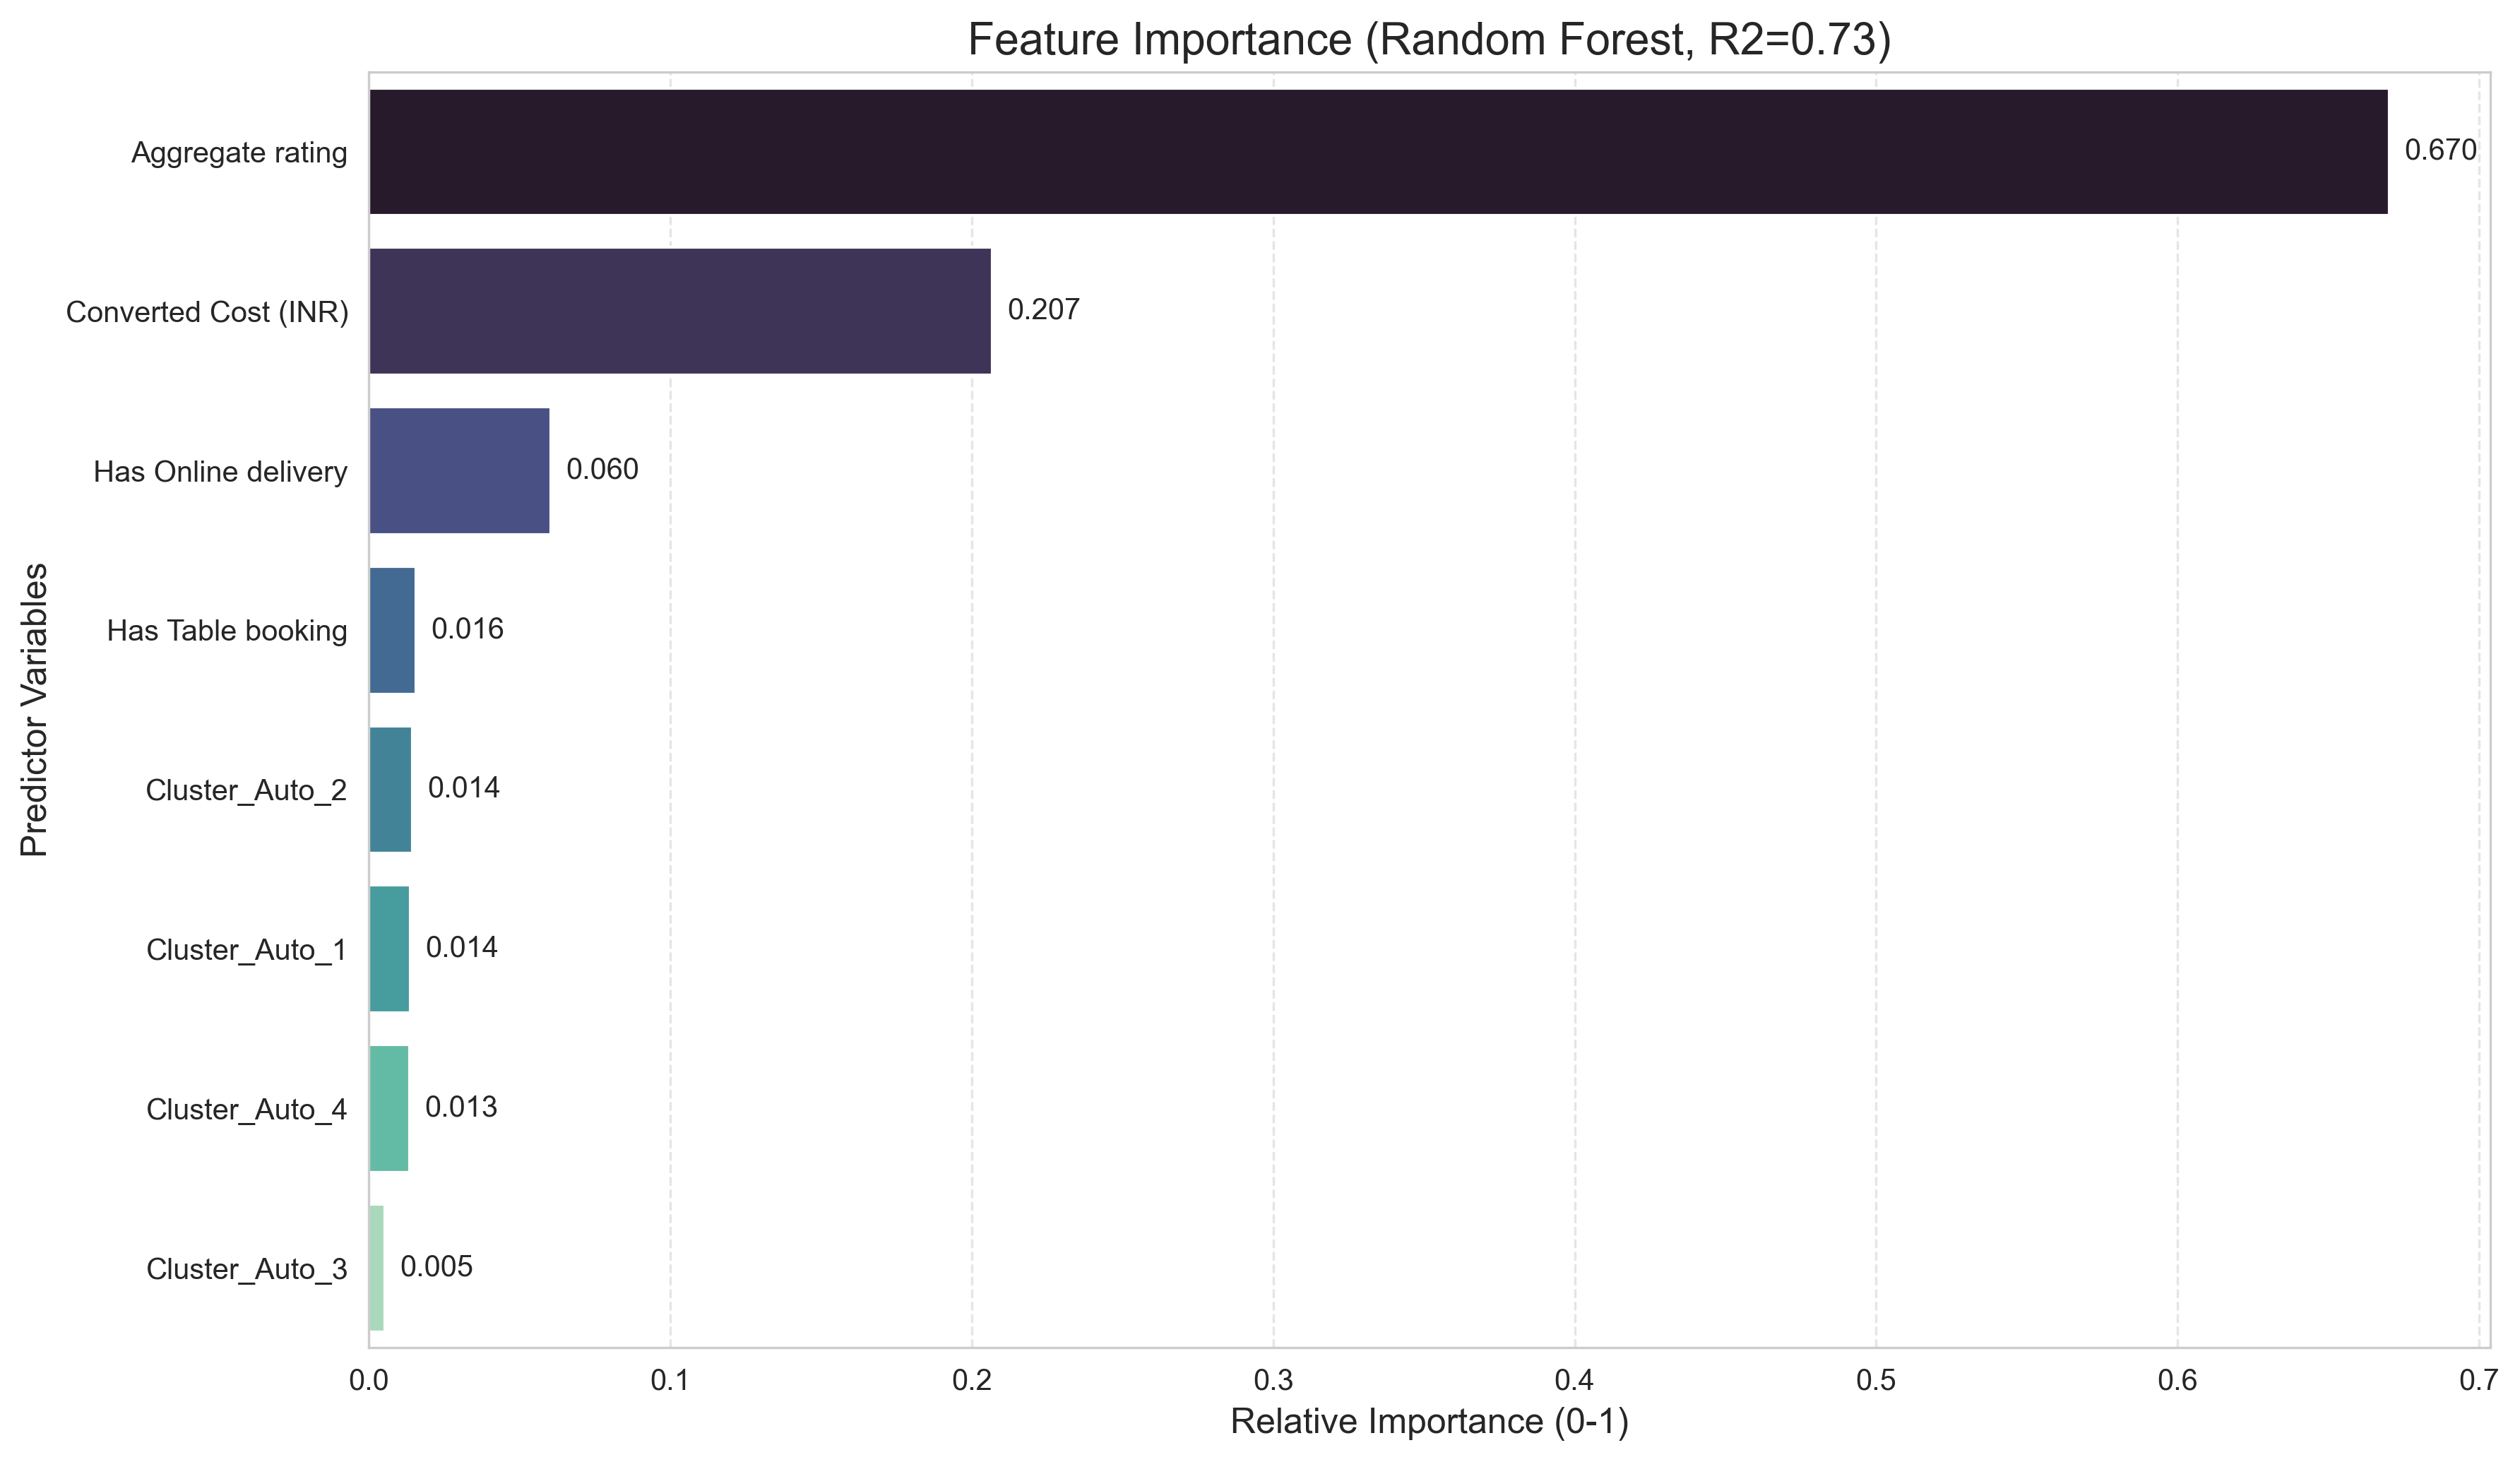

In [26]:
importances = best_model.feature_importances_
feature_names = X.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

feature_imp_df['Cumulative'] = feature_imp_df['Importance'].cumsum()
print(feature_imp_df.round(4))

plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_imp_df, 
    palette='mako'
)


for index, value in enumerate(feature_imp_df['Importance']):
    plt.text(value + 0.005, index, f'{value:.3f}', va='center', fontsize=10)

plt.title(f'Feature Importance (Random Forest, R2={r2_score(y_test_log, y_pred_test_rf):.2f})', fontsize=15)
plt.xlabel('Relative Importance (0-1)', fontsize=12)
plt.ylabel('Predictor Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('PNG/Feature Importance (Random Forest).png',dpi=500)
plt.show()

In [30]:
# Best model (Random Forest) to perform full prediction
all_preds_log = best_model.predict(X) 

# Restore to actual vote counts (exp)
df_model['predicted_votes_log'] = all_preds_log
df_model['predicted_votes'] = np.expm1(df_model['predicted_votes_log'])
df_model['actual_votes'] = df_model['Votes']

# Calculate the Undervaluation Index
df_model['Undervaluation_Index'] = (
    (df_model['predicted_votes'] - df_model['actual_votes']) / 
    (df_model['predicted_votes'] + 1)
) * 100

# Define labels
def get_market_label(row):
    idx = row['Undervaluation_Index']
    rating = row['Aggregate rating']
    
    # Hidden Gem: theoretical traffic much greater than actual, and food quality is good
    if idx > 50 and rating >= 4.0:
        return "Hidden Gem"
    # Viral Hit: actual traffic much greater than theoretical (overflow)
    elif idx < -500 and rating < 3.5:
        return "Viral Hit"
    else:
        return "Normal"

df_model['viz_status'] = df_model.apply(get_market_label, axis=1)
print(df_model.head())

   Unnamed: 0  Restaurant ID  Restaurant Name  Country Code       City  \
0        2561       18216944        Burger.In             1  New Delhi   
1        2562         313333  Days Of The Raj             1  New Delhi   
2        2562         313333  Days Of The Raj             1  New Delhi   
3        2562         313333  Days Of The Raj             1  New Delhi   
4        2563       18384127   Dilli Ka Dhaba             1  New Delhi   

                                             Address Locality  \
0        84, Near Honda Showroom, Adchini, New Delhi  Adchini   
1  81/3, 1st Floor, Qutub Residency, Adchini, New...  Adchini   
2  81/3, 1st Floor, Qutub Residency, Adchini, New...  Adchini   
3  81/3, 1st Floor, Qutub Residency, Adchini, New...  Adchini   
4  66 A, Ground Floor, Sri Aurobindo Marg, Adchin...  Adchini   

     Locality Verbose  Longitude   Latitude  ... Converted Cost (INR)  \
0  Adchini, New Delhi  77.196923  28.535382  ...                350.0   
1  Adchini, New De

In [41]:
# Count the number of restaurants in each category
label_counts = df_model['viz_status'].value_counts()

print(f"Hidden Gems: {label_counts.get('Hidden Gem', 0)}")
print(f"Viral Hits: {label_counts.get('Viral Hit', 0)}")
#print(f"Normal: {label_counts.get('Normal', 0)}")

Hidden Gems: 131
Viral Hits: 47


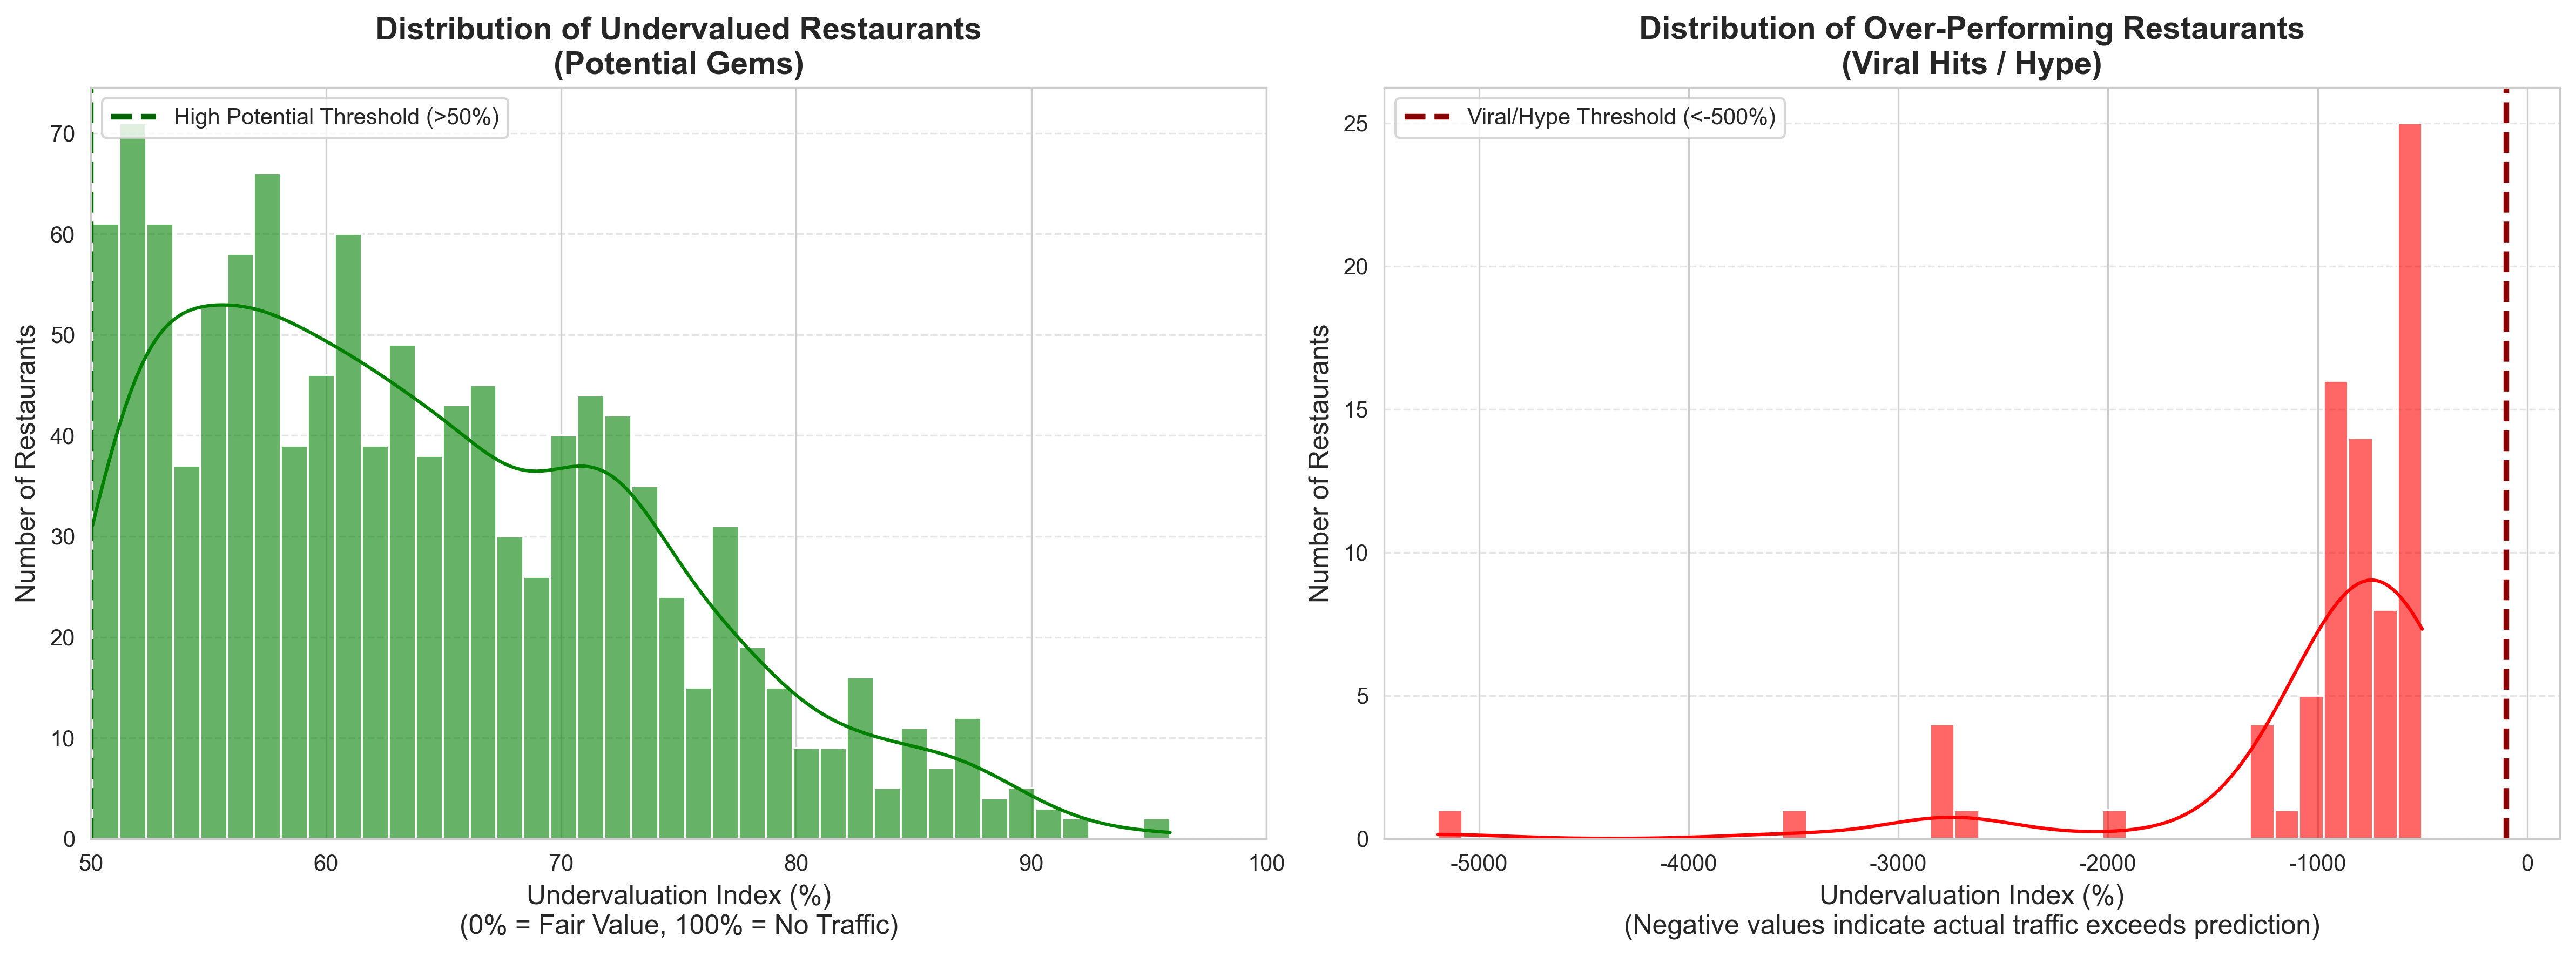

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot1: Undervalued Restaurants——Hidden Gems (Positive)
potential_data = df_model[df_model['Undervaluation_Index'] > 50]

sns.histplot(
    potential_data['Undervaluation_Index'], 
    bins=40, 
    kde=True, 
    color='green', 
    edgecolor='white',
    alpha=0.6,
    ax=axes[0]
)

axes[0].axvline(x=50, color='darkgreen', linestyle='--', linewidth=2.5, label='High Potential Threshold (>50%)')
axes[0].set_title('Distribution of Undervalued Restaurants\n(Potential Gems)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Undervaluation Index (%)\n(0% = Fair Value, 100% = No Traffic)', fontsize=12)
axes[0].set_ylabel('Number of Restaurants', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].set_xlim(50, 100)  # 锁定范围在0-100之间
axes[0].grid(axis='y', linestyle='--', alpha=0.5)


# Plot2: Over-Performing Restaurants——Vital Hits (Negative)
viral_data = df_model[df_model['Undervaluation_Index'] < -500]

sns.histplot(
    viral_data['Undervaluation_Index'], 
    bins=40, 
    kde=True, 
    color='red', 
    edgecolor='white',
    alpha=0.6,
    ax=axes[1]
)

axes[1].axvline(x=-100, color='darkred', linestyle='--', linewidth=2.5, label='Viral/Hype Threshold (<-500%)')
axes[1].set_title('Distribution of Over-Performing Restaurants\n(Viral Hits / Hype)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Undervaluation Index (%)\n(Negative values indicate actual traffic exceeds prediction)', fontsize=12)
axes[1].set_ylabel('Number of Restaurants', fontsize=12)
axes[1].legend(loc='upper left')
#axes[1].set_xlim(-500, 0) 
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PNG/Distribution of Undervalued and Over-Performing Restaurants.png',dpi=500)
plt.show()

In [39]:
import folium

# Initialize the map centered in India
m = folium.Map(location=[28.6139, 77.2090], zoom_start=11)

# Define color mapping, keeping only two categories
color_map = {
    "Hidden Gem": "green",
    "Viral Hit": "red"
}

# only display the two special categories
for _, row in df_model.iterrows():
    if row['viz_status'] in ["Hidden Gem", "Viral Hit"]:
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            color=color_map[row['viz_status']],
            fill=True,
            fill_opacity=0.8,
            popup=f"{row['Restaurant Name']} | Rating: {row['Aggregate rating']} | Votes: {row['Votes']}"
        ).add_to(m)

m.save("PNG/restaurant_map.html")
m

Plotting ready: Found 131 Hidden Gem restaurants, 47 Viral Hit restaurants.


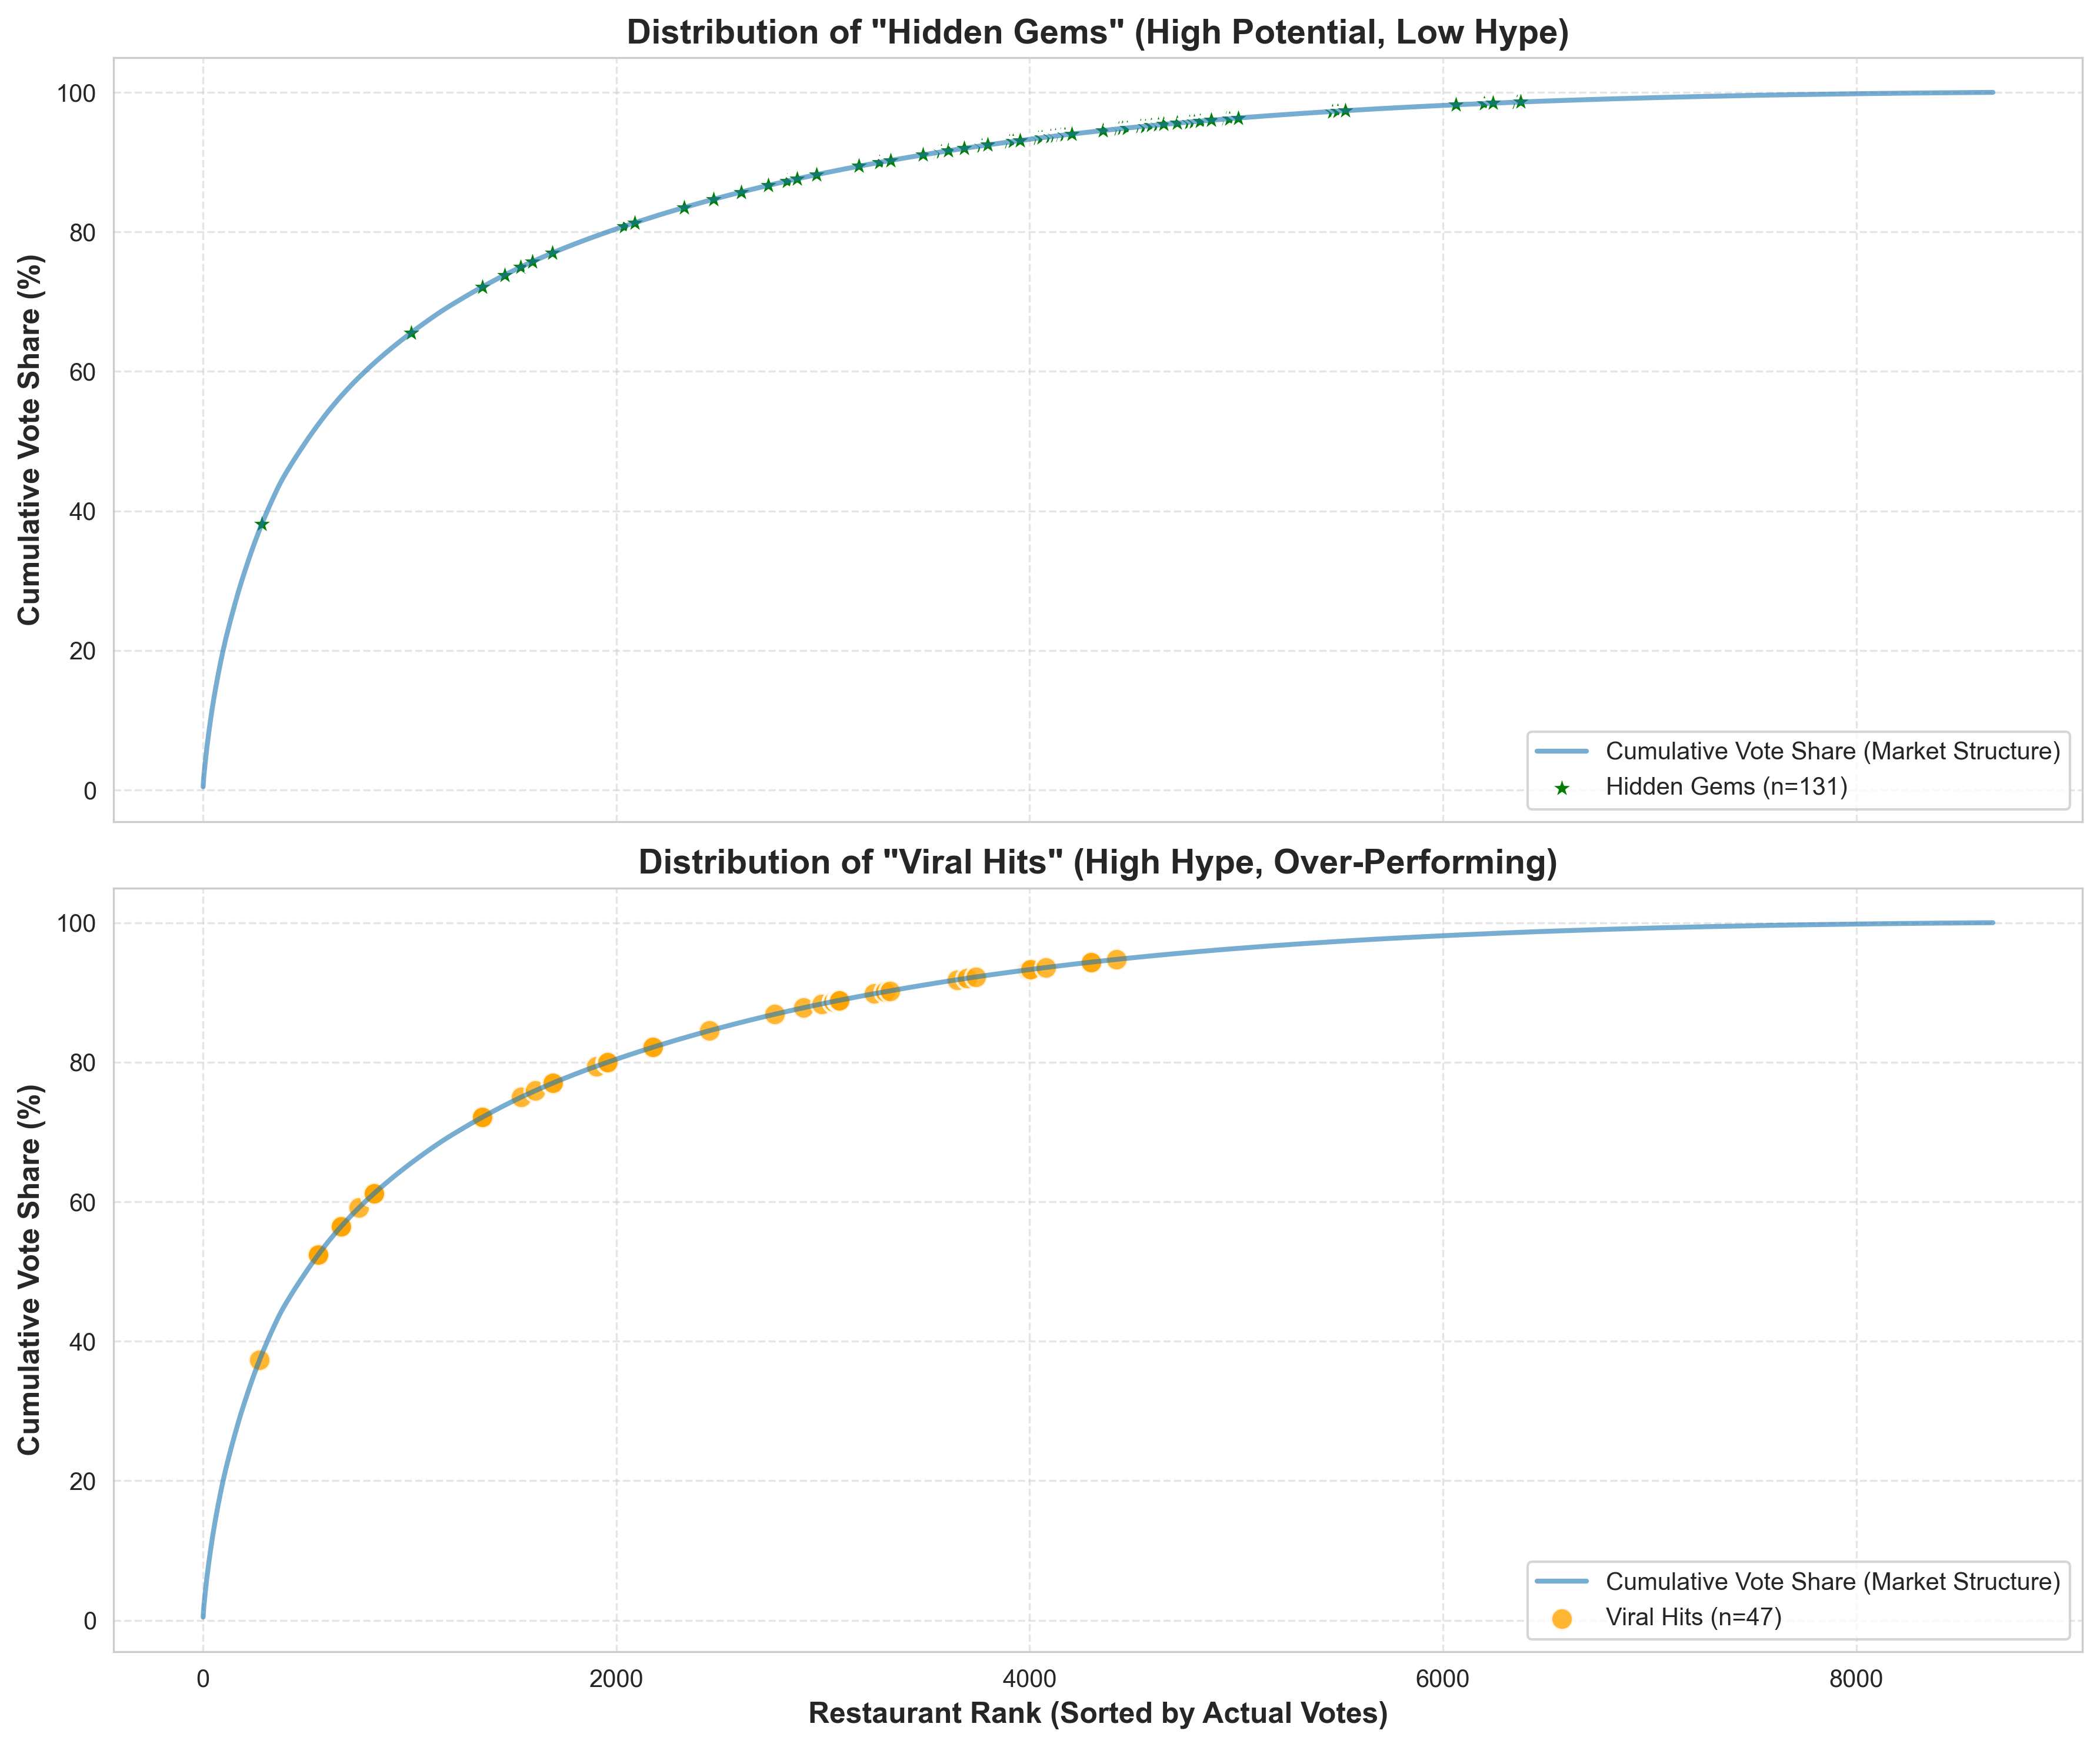

In [31]:
# ==========================================
# 2. Prepare plotting data: Long-tail distribution calculation
# ==========================================

# A. Sort by actual votes in descending order (basis for long-tail curve)
# reset_index is important so that index 0 = rank 1, index 1 = rank 2...
df_sorted = df_model.sort_values(by='Votes', ascending=False).reset_index(drop=True)

# B. Calculate cumulative vote percentage (Lorenz Curve logic)
votes_values = df_sorted['Votes'].values
cumsum_votes = np.cumsum(votes_values)
cumsum_pct = cumsum_votes / cumsum_votes[-1] * 100

# C. Generate ranks (X-axis)
ranks = np.arange(1, len(votes_values) + 1)

# D. Extract positions of the two special restaurant categories after sorting
# This allows us to locate their corresponding points on the curve
gems_points = df_sorted[df_sorted['viz_status'] == "Hidden Gem"]
viral_points = df_sorted[df_sorted['viz_status'] == "Viral Hit"]

print(f"Plotting ready: Found {len(gems_points)} Hidden Gem restaurants, {len(viral_points)} Viral Hit restaurants.")

# ==========================================
# 3. Visualization: Positioning within the long-tail distribution
# ==========================================
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Subplot 1: Hidden Gems ---
# Plot background long-tail curve
axes[0].plot(ranks, cumsum_pct, label='Cumulative Vote Share (Market Structure)', color='#1f77b4', linewidth=2, alpha=0.6)

# Plot scatter points
# x-axis is the rank (index+1), y-axis is the corresponding cumulative percentage (cumsum_pct)
axes[0].scatter(
    gems_points.index + 1, 
    cumsum_pct[gems_points.index], 
    color='green', 
    s=100, 
    marker='*', 
    edgecolors='white',
    label=f'Hidden Gems (n={len(gems_points)})'
)

axes[0].set_ylabel('Cumulative Vote Share (%)', fontweight='bold', fontsize=12)
axes[0].set_title('Distribution of "Hidden Gems" (High Potential, Low Hype)', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', frameon=True)
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Subplot 2: Viral Hits ---
# Plot background long-tail curve
axes[1].plot(ranks, cumsum_pct, label='Cumulative Vote Share (Market Structure)', color='#1f77b4', linewidth=2, alpha=0.6)

# Plot scatter points
axes[1].scatter(
    viral_points.index + 1, 
    cumsum_pct[viral_points.index], 
    color='orange', 
    s=80, 
    marker='o', 
    edgecolors='white',
    alpha=0.8,
    label=f'Viral Hits (n={len(viral_points)})'
)

axes[1].set_xlabel('Restaurant Rank (Sorted by Actual Votes)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Cumulative Vote Share (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Distribution of "Viral Hits" (High Hype, Over-Performing)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', frameon=True)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PNG/Long-tail_Distribution_Analysis.png', dpi=500)
# plt.savefig('Long-tail_Distribution_Analysis.png', dpi=300) # Uncomment if saving without PNG folder
plt.show()
# print(df_model)
# df_model.to_csv('HiddenGem-ViralHit_Identification.csv', index=False)
